In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    http://www.deeplearning.net/tutorial/lstm.html#lstm
    https://github.com/llSourcell/LSTM_Networks/blob/master/LSTM%20Demo.ipynb
    https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    Recurrent Neural Network.
    A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
    This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
    Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
    Author: Aymeric Damien
    Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module

H = 5
N = 50

#Reference: Denis
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    return np.expand_dims(sequences, axis=2), y

#Reference: Modified from Denis by Bo Cao
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    
    new_y = []
    for i in range(len(y)):
        new_yy = []
        if y[i] == 0:
            new_yy.append(0)
            new_yy.append(1)
        else:
            new_yy.append(1)
            new_yy.append(0)
        new_y.append(new_yy)

    return np.expand_dims(sequences, axis=2), new_y

In [2]:
# Training Parameters
learning_rate = 7.85
batch_size = 128
display_step = batch_size * 100

#batch_steps = 10000 / batch_size
epochs = 5000

# Network Parameters
num_input = 1 # 
timesteps = N # timesteps
num_hidden = H # hidden layer num of features
num_classes = 2 # 0 or 1

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
#prediction = tf.nn.softmax(logits)
prediction = tf.tanh(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

test_accuracies_10replications = []
minibatch_losses_1st_replication = [] #epoch as unit
test_accuracies_1st_replication = [] #epoch as unit
train_accuracies_1st_replication = [] #epoch as unit

# Start training
with tf.Session() as sess:
    
    # Run 10 replications
    for replication in range(10):
        
        print("Replication: %d: " % replication)
        
        # Initialize random weights
        train_data = generate_parity_sequences(N, 10000)
        train_data_x = train_data[0]
        train_data_y = train_data[1]
        test_data = generate_parity_sequences(N, 10000)
        test_data_x = test_data[0]
        test_data_y = test_data[1]
        
        # Run the initializer
        sess.run(init)
    
        for epoch in range(epochs):
            batch_index = 0
            while batch_index < 10000:

                train_data_batch_x = []
                train_data_batch_y = []
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_x[batch_index : batch_index + batch_size]
                    train_data_batch_y = train_data_y[batch_index : batch_index + batch_size]
                else:
                    train_data_batch_x = train_data_x[batch_index : ]
                    train_data_batch_y = train_data_y[batch_index : ]

                #batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                #batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                #train_data_x = train_data_x.reshape((10000, timesteps, num_input))
                #print("train_data_batch_x.shape:  " , train_data_batch_x.shape)
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_batch_x.reshape((batch_size, timesteps, num_input))
                else:
                    train_data_batch_x = train_data_batch_x.reshape((10000 % batch_size, timesteps, num_input))
                # Run optimization op (backprop)
                #sess.run(train_op, feed_dict={X: train_data_x, 
                 #                             Y: train_data_y})
                sess.run(train_op, feed_dict={X: train_data_batch_x, 
                                              Y: train_data_batch_y})

                batch_index += batch_size

            if replication == 0:
                loss, train_accuracy = sess.run([loss_op, accuracy], feed_dict={X: train_data_x, Y: train_data_y})
                test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
                minibatch_losses_1st_replication.append(loss)
                train_accuracies_1st_replication.append(train_accuracy)
                test_accuracies_1st_replication.append(test_accuracy)
            
            if epoch % 10 == 0:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: train_data_x,
                                                                         Y: train_data_y})
                print("Epoch: " + str(epoch) + \
                          ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))

        print("Optimization Finished!")

        test_data_x = test_data_x.reshape((-1, timesteps, num_input))
        test_data_y = test_data_y
        test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
        test_accuracies_10replications.append(test_accuracy)
        print("Testing Accuracy:", test_accuracy)
        

Replication: 0: 
Epoch: 0, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 10, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 20, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 30, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 40, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 50, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 60, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 70, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 80, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 90, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 100, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 110, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 120, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 130, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 140, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 150, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 160, Miniba

Epoch: 1340, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1350, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1360, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1370, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1380, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1390, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1400, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1410, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1420, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1430, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1440, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1450, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1460, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1470, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1480, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1490, Minibatch Loss= 2.3470, Training Accuracy= 0.499
Epoch: 1

Epoch: 2670, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2680, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2690, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2700, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2710, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2720, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2730, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2740, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2750, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2760, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2770, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2780, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2790, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2800, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2810, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2820, Minibatch Loss= 2.3471, Training Accuracy= 0.499
Epoch: 2

Epoch: 4000, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4010, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4020, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4030, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4040, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4050, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4060, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4070, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4080, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4090, Minibatch Loss= 2.3478, Training Accuracy= 0.499
Epoch: 4100, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4110, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4120, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4130, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4140, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4150, Minibatch Loss= 2.3479, Training Accuracy= 0.499
Epoch: 4

Epoch: 320, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 330, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 340, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 350, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 360, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 370, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 380, Minibatch Loss= 2.0923, Training Accuracy= 0.499
Epoch: 390, Minibatch Loss= 2.0924, Training Accuracy= 0.499
Epoch: 400, Minibatch Loss= 2.0924, Training Accuracy= 0.499
Epoch: 410, Minibatch Loss= 2.0924, Training Accuracy= 0.499
Epoch: 420, Minibatch Loss= 2.0924, Training Accuracy= 0.499
Epoch: 430, Minibatch Loss= 2.0924, Training Accuracy= 0.499
Epoch: 440, Minibatch Loss= 2.0925, Training Accuracy= 0.499
Epoch: 450, Minibatch Loss= 2.0925, Training Accuracy= 0.499
Epoch: 460, Minibatch Loss= 2.0925, Training Accuracy= 0.499
Epoch: 470, Minibatch Loss= 2.0925, Training Accuracy= 0.499
Epoch: 480, Minibatch Lo

Epoch: 1660, Minibatch Loss= 2.0951, Training Accuracy= 0.499
Epoch: 1670, Minibatch Loss= 2.0951, Training Accuracy= 0.499
Epoch: 1680, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1690, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1700, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1710, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1720, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1730, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1740, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1750, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1760, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1770, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1780, Minibatch Loss= 2.0952, Training Accuracy= 0.499
Epoch: 1790, Minibatch Loss= 2.0953, Training Accuracy= 0.499
Epoch: 1800, Minibatch Loss= 2.0953, Training Accuracy= 0.499
Epoch: 1810, Minibatch Loss= 2.0953, Training Accuracy= 0.499
Epoch: 1

Epoch: 2990, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3000, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3010, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3020, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3030, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3040, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3050, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3060, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3070, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3080, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3090, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3100, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3110, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3120, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3130, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3140, Minibatch Loss= 2.0964, Training Accuracy= 0.499
Epoch: 3

Epoch: 4320, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4330, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4340, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4350, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4360, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4370, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4380, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4390, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4400, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4410, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4420, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4430, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4440, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4450, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4460, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4470, Minibatch Loss= 2.0965, Training Accuracy= 0.499
Epoch: 4

Epoch: 650, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 660, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 670, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 680, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 690, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 700, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 710, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 720, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 730, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 740, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 750, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 760, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 770, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 780, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 790, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 800, Minibatch Loss= 3.4300, Training Accuracy= 0.508
Epoch: 810, Minibatch Lo

Epoch: 1980, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 1990, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2000, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2010, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2020, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2030, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2040, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2050, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2060, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2070, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2080, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2090, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2100, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2110, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2120, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2130, Minibatch Loss= 3.4301, Training Accuracy= 0.508
Epoch: 2

Epoch: 3310, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3320, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3330, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3340, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3350, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3360, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3370, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3380, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3390, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3400, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3410, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3420, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3430, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3440, Minibatch Loss= 3.4303, Training Accuracy= 0.508
Epoch: 3450, Minibatch Loss= 3.4304, Training Accuracy= 0.508
Epoch: 3460, Minibatch Loss= 3.4304, Training Accuracy= 0.508
Epoch: 3

Epoch: 4640, Minibatch Loss= 3.4306, Training Accuracy= 0.508
Epoch: 4650, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4660, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4670, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4680, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4690, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4700, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4710, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4720, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4730, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4740, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4750, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4760, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4770, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4780, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4790, Minibatch Loss= 3.4307, Training Accuracy= 0.508
Epoch: 4

Epoch: 970, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 980, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 990, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1000, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1010, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1020, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1030, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1040, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1050, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1060, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1070, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1080, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1090, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1100, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1110, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1120, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 1130

Epoch: 2300, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2310, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2320, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2330, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2340, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2350, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2360, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2370, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2380, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2390, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2400, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2410, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2420, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2430, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2440, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2450, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 2

Epoch: 3630, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3640, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3650, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3660, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3670, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3680, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3690, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3700, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3710, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3720, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3730, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3740, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3750, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3760, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3770, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3780, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 3

Epoch: 4960, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 4970, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 4980, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Epoch: 4990, Minibatch Loss= 1.3354, Training Accuracy= 0.494
Optimization Finished!
Testing Accuracy: 0.5019
Replication: 4: 
Epoch: 0, Minibatch Loss= 3.4148, Training Accuracy= 0.511
Epoch: 10, Minibatch Loss= 3.4114, Training Accuracy= 0.511
Epoch: 20, Minibatch Loss= 3.4109, Training Accuracy= 0.511
Epoch: 30, Minibatch Loss= 3.4106, Training Accuracy= 0.511
Epoch: 40, Minibatch Loss= 3.4102, Training Accuracy= 0.511
Epoch: 50, Minibatch Loss= 3.4099, Training Accuracy= 0.511
Epoch: 60, Minibatch Loss= 3.4096, Training Accuracy= 0.511
Epoch: 70, Minibatch Loss= 3.4093, Training Accuracy= 0.511
Epoch: 80, Minibatch Loss= 3.4090, Training Accuracy= 0.511
Epoch: 90, Minibatch Loss= 3.4087, Training Accuracy= 0.511
Epoch: 100, Minibatch Loss= 3.4084, Training Accuracy= 0.511
Epoch: 110, Minibatch Loss=

Epoch: 1290, Minibatch Loss= 3.4012, Training Accuracy= 0.511
Epoch: 1300, Minibatch Loss= 3.4012, Training Accuracy= 0.511
Epoch: 1310, Minibatch Loss= 3.4011, Training Accuracy= 0.511
Epoch: 1320, Minibatch Loss= 3.4011, Training Accuracy= 0.511
Epoch: 1330, Minibatch Loss= 3.4010, Training Accuracy= 0.511
Epoch: 1340, Minibatch Loss= 3.4009, Training Accuracy= 0.511
Epoch: 1350, Minibatch Loss= 3.4007, Training Accuracy= 0.511
Epoch: 1360, Minibatch Loss= 3.4005, Training Accuracy= 0.511
Epoch: 1370, Minibatch Loss= 3.4003, Training Accuracy= 0.511
Epoch: 1380, Minibatch Loss= 3.4001, Training Accuracy= 0.511
Epoch: 1390, Minibatch Loss= 3.3999, Training Accuracy= 0.511
Epoch: 1400, Minibatch Loss= 3.3997, Training Accuracy= 0.511
Epoch: 1410, Minibatch Loss= 3.3995, Training Accuracy= 0.511
Epoch: 1420, Minibatch Loss= 3.3994, Training Accuracy= 0.511
Epoch: 1430, Minibatch Loss= 3.3993, Training Accuracy= 0.511
Epoch: 1440, Minibatch Loss= 3.3992, Training Accuracy= 0.511
Epoch: 1

Epoch: 2620, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2630, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2640, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2650, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2660, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2670, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2680, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2690, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2700, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2710, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2720, Minibatch Loss= 3.3980, Training Accuracy= 0.511
Epoch: 2730, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2740, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2750, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2760, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2770, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 2

Epoch: 3950, Minibatch Loss= 3.3983, Training Accuracy= 0.511
Epoch: 3960, Minibatch Loss= 0.7984, Training Accuracy= 0.489
Epoch: 3970, Minibatch Loss= 3.4009, Training Accuracy= 0.511
Epoch: 3980, Minibatch Loss= 3.3995, Training Accuracy= 0.511
Epoch: 3990, Minibatch Loss= 3.3984, Training Accuracy= 0.511
Epoch: 4000, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 4010, Minibatch Loss= 0.7985, Training Accuracy= 0.489
Epoch: 4020, Minibatch Loss= 3.4007, Training Accuracy= 0.511
Epoch: 4030, Minibatch Loss= 3.3993, Training Accuracy= 0.511
Epoch: 4040, Minibatch Loss= 3.3983, Training Accuracy= 0.511
Epoch: 4050, Minibatch Loss= 0.7984, Training Accuracy= 0.489
Epoch: 4060, Minibatch Loss= 3.4009, Training Accuracy= 0.511
Epoch: 4070, Minibatch Loss= 3.3995, Training Accuracy= 0.511
Epoch: 4080, Minibatch Loss= 3.3984, Training Accuracy= 0.511
Epoch: 4090, Minibatch Loss= 3.3979, Training Accuracy= 0.511
Epoch: 4100, Minibatch Loss= 0.7985, Training Accuracy= 0.489
Epoch: 4

Epoch: 270, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 280, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 290, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 300, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 310, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 320, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 330, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 340, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 350, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 360, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 370, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 380, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 390, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 400, Minibatch Loss= 2.4401, Training Accuracy= 0.497
Epoch: 410, Minibatch Loss= 2.4400, Training Accuracy= 0.497
Epoch: 420, Minibatch Loss= 2.4400, Training Accuracy= 0.497
Epoch: 430, Minibatch Lo

Epoch: 1610, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1620, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1630, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1640, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1650, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1660, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1670, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1680, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1690, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1700, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1710, Minibatch Loss= 2.4376, Training Accuracy= 0.497
Epoch: 1720, Minibatch Loss= 2.4375, Training Accuracy= 0.497
Epoch: 1730, Minibatch Loss= 2.4375, Training Accuracy= 0.497
Epoch: 1740, Minibatch Loss= 2.4375, Training Accuracy= 0.497
Epoch: 1750, Minibatch Loss= 2.4375, Training Accuracy= 0.497
Epoch: 1760, Minibatch Loss= 2.4375, Training Accuracy= 0.497
Epoch: 1

Epoch: 2940, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 2950, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 2960, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 2970, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 2980, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 2990, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3000, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3010, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3020, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3030, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3040, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3050, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3060, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3070, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3080, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3090, Minibatch Loss= 2.4363, Training Accuracy= 0.497
Epoch: 3

Epoch: 4270, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4280, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4290, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4300, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4310, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4320, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4330, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4340, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4350, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4360, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4370, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4380, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4390, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4400, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4410, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4420, Minibatch Loss= 2.4361, Training Accuracy= 0.497
Epoch: 4

Epoch: 600, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 610, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 620, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 630, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 640, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 650, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 660, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 670, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 680, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 690, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 700, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 710, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 720, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 730, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 740, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 750, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 760, Minibatch Lo

Epoch: 1930, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1940, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1950, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1960, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1970, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1980, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 1990, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2000, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2010, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2020, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2030, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2040, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2050, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2060, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2070, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2080, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 2

Epoch: 3260, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3270, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3280, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3290, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3300, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3310, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3320, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3330, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3340, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3350, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3360, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3370, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3380, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3390, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3400, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3410, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 3

Epoch: 4590, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4600, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4610, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4620, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4630, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4640, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4650, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4660, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4670, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4680, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4690, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4700, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4710, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4720, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4730, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4740, Minibatch Loss= 2.7291, Training Accuracy= 0.497
Epoch: 4

Epoch: 920, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 930, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 940, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 950, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 960, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 970, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 980, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 990, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1000, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1010, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1020, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1030, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1040, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1050, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1060, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1070, Minibatch Loss= 0.8014, Training Accuracy= 0.496
Epoch: 1080, Min

Epoch: 2250, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2260, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2270, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2280, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2290, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2300, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2310, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2320, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2330, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2340, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2350, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2360, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2370, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2380, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2390, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2400, Minibatch Loss= 0.8015, Training Accuracy= 0.496
Epoch: 2

Epoch: 3580, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3590, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3600, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3610, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3620, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3630, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3640, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3650, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3660, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3670, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3680, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3690, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3700, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3710, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3720, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3730, Minibatch Loss= 0.8016, Training Accuracy= 0.496
Epoch: 3

Epoch: 4910, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4920, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4930, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4940, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4950, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4960, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4970, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4980, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Epoch: 4990, Minibatch Loss= 0.8017, Training Accuracy= 0.496
Optimization Finished!
Testing Accuracy: 0.5029
Replication: 8: 
Epoch: 0, Minibatch Loss= 2.0019, Training Accuracy= 0.512
Epoch: 10, Minibatch Loss= 1.9999, Training Accuracy= 0.512
Epoch: 20, Minibatch Loss= 1.9998, Training Accuracy= 0.512
Epoch: 30, Minibatch Loss= 1.9997, Training Accuracy= 0.512
Epoch: 40, Minibatch Loss= 1.9997, Training Accuracy= 0.512
Epoch: 50, Minibatch Loss= 1.9997, Training Accuracy= 0.512
Epoch: 60, Minibat

Epoch: 1240, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1250, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1260, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1270, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1280, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1290, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1300, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1310, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1320, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1330, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1340, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1350, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1360, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1370, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1380, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1390, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 1

Epoch: 2570, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2580, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2590, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2600, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2610, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2620, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2630, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2640, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2650, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2660, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2670, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2680, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2690, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2700, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2710, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2720, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 2

Epoch: 3900, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3910, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3920, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3930, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3940, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3950, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3960, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3970, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3980, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 3990, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4000, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4010, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4020, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4030, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4040, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4050, Minibatch Loss= 1.9996, Training Accuracy= 0.512
Epoch: 4

Epoch: 220, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 230, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 240, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 250, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 260, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 270, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 280, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 290, Minibatch Loss= 2.5288, Training Accuracy= 0.498
Epoch: 300, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 310, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 320, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 330, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 340, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 350, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 360, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 370, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 380, Minibatch Lo

Epoch: 1560, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1570, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1580, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1590, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1600, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1610, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1620, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1630, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1640, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1650, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1660, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1670, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1680, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1690, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1700, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1710, Minibatch Loss= 2.5289, Training Accuracy= 0.498
Epoch: 1

Epoch: 2890, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2900, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2910, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2920, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2930, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2940, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2950, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2960, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2970, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2980, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 2990, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3000, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3010, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3020, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3030, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3040, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 3

Epoch: 4220, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4230, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4240, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4250, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4260, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4270, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4280, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4290, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4300, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4310, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4320, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4330, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4340, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4350, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4360, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4370, Minibatch Loss= 2.5319, Training Accuracy= 0.498
Epoch: 4

In [3]:
# print results
test_accuracies_10replications_std = np.std(test_accuracies_10replications, axis=0)
test_accuracies_10replications_std_mean = test_accuracies_10replications_std / np.square(10)
print("test_accuracies_10replications: ", test_accuracies_10replications)
print("mean of test_accuracies_10replications: ", np.mean(test_accuracies_10replications))
print("standard deviation of test_accuracies_10replications_std_mean: ", test_accuracies_10replications_std_mean)

test_accuracies_10replications:  [0.50029999, 0.50139999, 0.49419999, 0.50190002, 0.4973, 0.50340003, 0.50569999, 0.5029, 0.49959999, 0.49970001]
mean of test_accuracies_10replications:  0.50064
standard deviation of test_accuracies_10replications_std_mean:  3.08551848866e-05


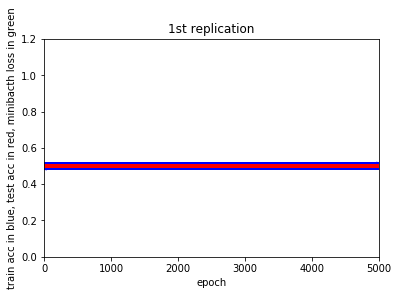

In [4]:
minibatch_losses_1st_replication
plt.plot(minibatch_losses_1st_replication, color='green', linewidth=5)
plt.plot(train_accuracies_1st_replication, color='blue', linewidth=7)
plt.plot(test_accuracies_1st_replication, color='red', linewidth=3)
plt.xlim(0, epochs)
plt.xlabel("epoch")
plt.ylim(0, 1.2)
plt.ylabel("train acc in blue, test acc in red, minibacth loss in green")
plt.title("1st replication")
plt.show()